In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from snowflake.snowpark import Session

In [2]:
load_dotenv()

True

In [3]:
os.chdir("/Users/theothormann/Desktop/Data Science/Capstone/Code/setup")
os.getcwd()


connection_parameters = {
    "account": os.getenv('ACCOUNT'),
    "user": 'theoatuva',
    "password": os.getenv('PASSWORD'),
    "role": os.getenv('ROLE'),
    "warehouse": os.getenv('WAREHOUSE'),
    "database": os.getenv('DATABASE'),
    "schema": os.getenv('SCHEMA')}

In [4]:
test_session = Session.builder.configs(connection_parameters).create()

In [5]:
events_query = """
SELECT 
    e.visitor_id
    , COUNT(DISTINCT e.id) AS events
    , COUNT(DISTINCT CASE WHEN e.event = 'cite' THEN e.id END) AS cite
    , COUNT(DISTINCT CASE WHEN e.event = 'pageview' THEN e.id END) AS page_view
    , COUNT(DISTINCT CASE WHEN e.event = 'pdf-click' THEN e.id END) AS pdf_click
    , COUNT(DISTINCT CASE WHEN e.event = 'post-read-start' THEN e.id END) AS post_read_start
    , COUNT(DISTINCT CASE WHEN e.event = 'post-read-mid' THEN e.id END) AS post_read_mid
    , COUNT(DISTINCT CASE WHEN e.event = 'post-read-end' THEN e.id END) AS post_read_end
FROM event e
WHERE DATE_TRUNC('year', e.day) = DATE('2022-01-01')
AND e.visitor_id IS NOT NULL
GROUP BY 1
ORDER BY 1
"""

In [6]:
print('querying...')
query_results = test_session.sql(events_query).collect()
print('query done')
test_session.close()
print('session closed')

querying...
query done
session closed


In [7]:
# convert to pandas df
query_json = list(map(lambda x: x.as_dict(), query_results))
query_df = pd.DataFrame(query_json)
query_df.to_csv('hist_data.csv', index = 0)
# query_df = pd.read_csv('events_data.csv')

In [8]:
query_df

,VISITOR_ID,EVENTS,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END
0,00000404-5bf6-4798-89d8-1592758d661e,3,0,3,0,0,0,0
1,000008b9-45d5-4ed2-8cfe-2463853d5640,4,0,1,0,1,1,1
2,00001624-b501-4b87-8cd6-a90760e47df8,4,0,1,0,1,1,1
3,00001e6f-ce60-4bf4-b356-4ab63181ccc3,4,0,1,0,1,1,1
4,00002124-5ca5-4a6f-9fd9-839062c866b3,8,0,2,0,2,2,2
...,...,...,...,...,...,...,...,...
1893500,ffffd7ea-c335-412e-a6f9-1676e2533cd5,12,0,3,0,3,3,3
1893501,ffffd8d1-e23e-49d4-9a1d-f24244edaeea,4,0,1,0,1,1,1
1893502,ffffe48e-5fde-4163-8e92-5d0d95bbc91a,1,0,1,0,0,0,0
1893503,ffffe76a-5434-4064-9cc3-274504915aeb,5,0,2,0,1,1,1


In [9]:
query_df.describe()

,EVENTS,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END
count,1.893505e+06,1.893505e+06,1.893505e+06,1.893505e+06,1.893505e+06,1.893505e+06,1.893505e+06
mean,5.737228e+00,5.017151e-05,2.628655e+00,9.363588e-04,1.093967e+00,1.041973e+00,9.716452e-01
std,1.306238e+02,8.505887e-03,1.214717e+02,3.511898e-02,1.010531e+01,9.745656e+00,8.424322e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,4.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,6.795700e+04,6.000000e+00,6.641900e+04,9.000000e+00,4.689000e+03,4.564000e+03,4.053000e+03


In [10]:
hist_df = query_df[[
    'EVENTS', 
    'CITE', 
    'PAGE_VIEW', 
    'PDF_CLICK',
    'POST_READ_START',
    'POST_READ_MID',
    'POST_READ_END'
]]

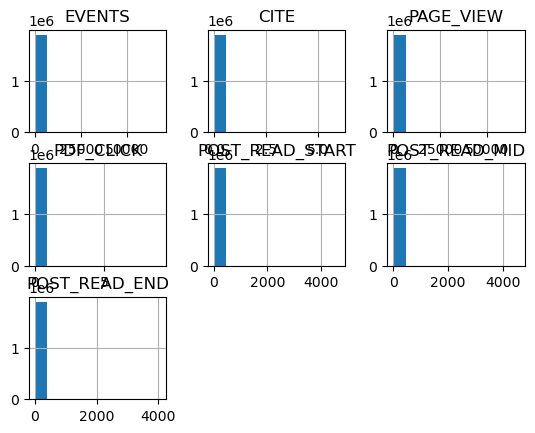

In [11]:
hist = hist_df.hist()

<AxesSubplot:>

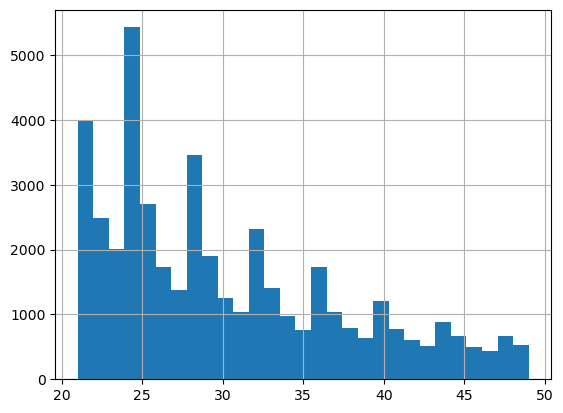

In [12]:
# remove outlier big events
hist_df['EVENTS'].where(lambda x: (x < 50) & (x > 20)).hist(bins = 29)

# spike every ~4 events, most users have ~4 events only
# figure out:
# 1. cyclicity
# 2. 20-50 events is good range to use - 12 different events, need at least 10x that
# each category should have >120 (more is better); 80-20 train-test split
# try 20-50 range vs 40-50 range at some point

In [13]:
list(hist_df.loc[:, hist_df.columns != 'EVENTS'].columns)

['CITE',
 'PAGE_VIEW',
 'PDF_CLICK',
 'POST_READ_START',
 'POST_READ_MID',
 'POST_READ_END']

In [14]:
smaller1 = hist_df[(hist_df['EVENTS'] < 20)]
smaller2 = hist_df[(hist_df['EVENTS'] < 50) & (hist_df['EVENTS'] >= 20)]

In [15]:
smaller1

,EVENTS,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END
0,3,0,3,0,0,0,0
1,4,0,1,0,1,1,1
2,4,0,1,0,1,1,1
3,4,0,1,0,1,1,1
4,8,0,2,0,2,2,2
...,...,...,...,...,...,...,...
1893500,12,0,3,0,3,3,3
1893501,4,0,1,0,1,1,1
1893502,1,0,1,0,0,0,0
1893503,5,0,2,0,1,1,1


In [16]:
hist1 = smaller1.groupby(by='EVENTS').sum()

In [17]:
hist1

,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END
EVENTS,,,,,,
1,0,634053,0,76,81,73
2,0,230865,6,22579,1051,883
3,0,168363,2,41871,38571,4609
4,0,702420,24,612702,607575,602971
5,16,150978,456,47341,43763,39951
6,1,95666,43,25996,19911,14035
7,0,75050,16,22688,19909,11557
8,1,264359,20,221254,218556,215522
9,9,90617,184,39637,37628,34461


In [18]:
percent1 = hist1.copy()
percent1['TOTALS'] = hist1.sum(axis=1)
percent1

,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END,TOTALS
EVENTS,,,,,,,
1,0,634053,0,76,81,73,634283
2,0,230865,6,22579,1051,883,255384
3,0,168363,2,41871,38571,4609,253416
4,0,702420,24,612702,607575,602971,2525692
5,16,150978,456,47341,43763,39951,282505
6,1,95666,43,25996,19911,14035,155652
7,0,75050,16,22688,19909,11557,129220
8,1,264359,20,221254,218556,215522,919712
9,9,90617,184,39637,37628,34461,202536


In [19]:
percent1['PAGE_VIEW_PERCENT'] = percent1['PAGE_VIEW']/percent1['TOTALS']
percent1['POST_READ_START_PERCENT'] = percent1['POST_READ_START']/percent1['TOTALS']
percent1['POST_READ_MID_PERCENT'] =percent1['POST_READ_MID']/percent1['TOTALS']
percent1['POST_READ_END_PERCENT'] = percent1['POST_READ_END']/percent1['TOTALS']

In [20]:
percent1

,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END,TOTALS,PAGE_VIEW_PERCENT,POST_READ_START_PERCENT,POST_READ_MID_PERCENT,POST_READ_END_PERCENT
EVENTS,,,,,,,,,,,
1,0,634053,0,76,81,73,634283,0.999637,0.000120,0.000128,0.000115
2,0,230865,6,22579,1051,883,255384,0.903992,0.088412,0.004115,0.003458
3,0,168363,2,41871,38571,4609,253416,0.664374,0.165226,0.152204,0.018187
4,0,702420,24,612702,607575,602971,2525692,0.278110,0.242588,0.240558,0.238735
5,16,150978,456,47341,43763,39951,282505,0.534426,0.167576,0.154911,0.141417
6,1,95666,43,25996,19911,14035,155652,0.614615,0.167014,0.127920,0.090169
7,0,75050,16,22688,19909,11557,129220,0.580792,0.175577,0.154071,0.089437
8,1,264359,20,221254,218556,215522,919712,0.287437,0.240569,0.237635,0.234336
9,9,90617,184,39637,37628,34461,202536,0.447412,0.195703,0.185784,0.170148


<AxesSubplot:xlabel='EVENTS'>

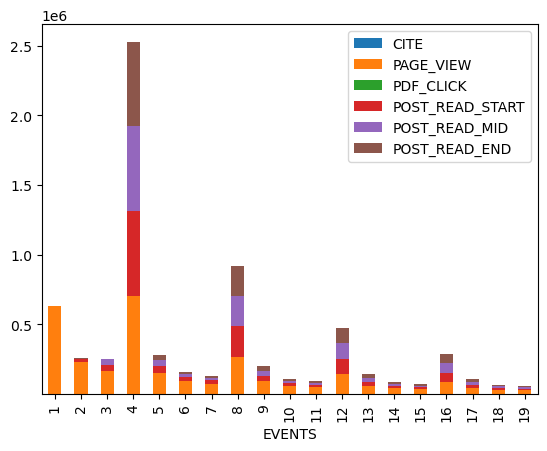

In [21]:
hist1.plot(kind='bar', stacked=True)

In [22]:
smaller2

,EVENTS,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END
69,30,0,20,0,4,4,2
119,48,0,12,0,12,12,12
144,36,0,9,0,9,9,9
181,22,0,13,0,7,2,0
254,22,0,9,0,7,3,3
...,...,...,...,...,...,...,...
1893383,33,0,11,0,8,8,6
1893386,20,0,5,0,5,5,5
1893391,22,0,7,0,5,5,5
1893435,33,0,9,0,8,8,8


In [23]:
hist2 = smaller2.groupby(by='EVENTS').sum()

In [24]:
hist2

,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END
EVENTS,,,,,,
20,0,58111,10,44009,43111,41919
21,3,32882,28,17908,17046,15986
22,4,24461,36,11035,10114,9042
23,0,21141,9,9282,8446,7191
24,0,41311,7,30407,29752,28771
25,1,26026,20,14720,13856,13052
26,0,19466,20,9204,8488,7646
27,1,16669,15,7506,6882,5944
28,1,31386,16,22487,21911,21051


In [25]:
percent2 = hist2.copy()
percent2['TOTALS'] = hist2.sum(axis=1)
percent2

,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END,TOTALS
EVENTS,,,,,,,
20,0,58111,10,44009,43111,41919,187160
21,3,32882,28,17908,17046,15986,83853
22,4,24461,36,11035,10114,9042,54692
23,0,21141,9,9282,8446,7191,46069
24,0,41311,7,30407,29752,28771,130248
25,1,26026,20,14720,13856,13052,67675
26,0,19466,20,9204,8488,7646,44824
27,1,16669,15,7506,6882,5944,37017
28,1,31386,16,22487,21911,21051,96852


In [26]:
percent2['PAGE_VIEW_PERCENT'] = percent2['PAGE_VIEW']/percent2['TOTALS']
percent2['POST_READ_START_PERCENT'] = percent2['POST_READ_START']/percent2['TOTALS']
percent2['POST_READ_MID_PERCENT'] = percent2['POST_READ_MID']/percent2['TOTALS']
percent2['POST_READ_END_PERCENT'] = percent2['POST_READ_END']/percent2['TOTALS']

In [27]:
percent2

,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END,TOTALS,PAGE_VIEW_PERCENT,POST_READ_START_PERCENT,POST_READ_MID_PERCENT,POST_READ_END_PERCENT
EVENTS,,,,,,,,,,,
20,0,58111,10,44009,43111,41919,187160,0.310488,0.235141,0.230343,0.223974
21,3,32882,28,17908,17046,15986,83853,0.392139,0.213564,0.203284,0.190643
22,4,24461,36,11035,10114,9042,54692,0.447250,0.201766,0.184926,0.165326
23,0,21141,9,9282,8446,7191,46069,0.458899,0.201480,0.183334,0.156092
24,0,41311,7,30407,29752,28771,130248,0.317172,0.233455,0.228426,0.220894
25,1,26026,20,14720,13856,13052,67675,0.384573,0.217510,0.204743,0.192863
26,0,19466,20,9204,8488,7646,44824,0.434276,0.205336,0.189363,0.170578
27,1,16669,15,7506,6882,5944,37017,0.450307,0.202772,0.185915,0.160575
28,1,31386,16,22487,21911,21051,96852,0.324061,0.232179,0.226232,0.217352


<AxesSubplot:xlabel='EVENTS'>

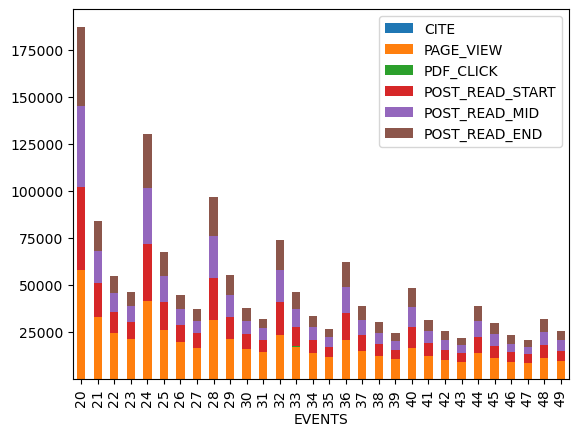

In [28]:
hist2.plot(kind='bar', stacked=True)